# 04 South Downs National Park NDVI

In this notebook we will investigate NDVI across the National Park by building median monthly profiles for Vegetation Health across the park. We will looks at all available images for a year and calculate the parkwide images from 160 slices. This would not be achievable or practical without the compute being next to the cube

In [19]:
import datacube
import geopandas as gpd
import sys
sys.path.append('./utils')
import jncc_utils
import numpy as np
import pandas as pd
import rasterio
import xarray as xr
import matplotlib.pyplot as plt
from datacube.utils import masking

Read in a year's worth of data (2019)

In [2]:
gdf = gpd.read_file('./data/SDNP.shp')

dc = datacube.Datacube()

query = {
    'time': ('2019-01-01','2019-12-31'),
    'output_crs': 'epsg:27700',
    'x': (gdf.total_bounds[0], gdf.total_bounds[2]),
    'y': (gdf.total_bounds[1], gdf.total_bounds[3]),
    'crs': 'epsg:27700',
    'resolution': (-10,10)
}

ds = dc.load(product='sentinel2',
            dask_chunks = {},
            **query)
ds

<xarray.Dataset>
Dimensions:      (time: 160, y: 4940, x: 11371)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-02T11:14:41 ... 2019-12-30T11:...
  * y            (y) float64 1.444e+05 1.444e+05 ... 9.506e+04 9.504e+04
  * x            (x) float64 4.466e+05 4.467e+05 ... 5.603e+05 5.603e+05
    spatial_ref  int32 27700
Data variables: (12/13)
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    rededge1     (time, y, x) uint16 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    rededge2     (time, y, x) uint16 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    rededge3     (time, y, x) uint16 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    ...           ...
    nir2         (time, y, x) uint16 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    swir1        (time, y, x) uint16 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    swir2        (time, y, x) uint16 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    fmask        (time, y, x) uint8 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    vmask        (time, y, x) uint8 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
    topomask     (time, y, x) uint8 dask.array<chunksize=(1, 4940, 11371), meta=np.ndarray>
Attributes:
    crs:           EPSG:27700
    grid_mapping:  spatial_ref

To get a sense for how many 'good' cloud free or partially cloud free images of the park we get lets filter using the valid mask > 50 % and then get the mean cloud pixels across the scene

In [3]:
times = list(ds.time.values)
percentage_list=[]
time_filter=[]
for count, value in enumerate(times):
    valid = ds.vmask.isel(time=count).values
    valid_mean = valid.mean()
    #print(valid_mean)
    if valid_mean > 0.50:
        data = ds.fmask.isel(time=count).values
        data2 = xr.where(data == 2, 1, data)
        data3 = data2.mean()
        percentage_list.append(data3)
        time_filter.append(value)

data = {"time": time_filter,"clean_percentage": percentage_list}

df = pd.DataFrame(data=data, columns=["time", "clean_percentage"])

Plot a years worth up - the distribution shows just how many images we have that are boarderline unusable

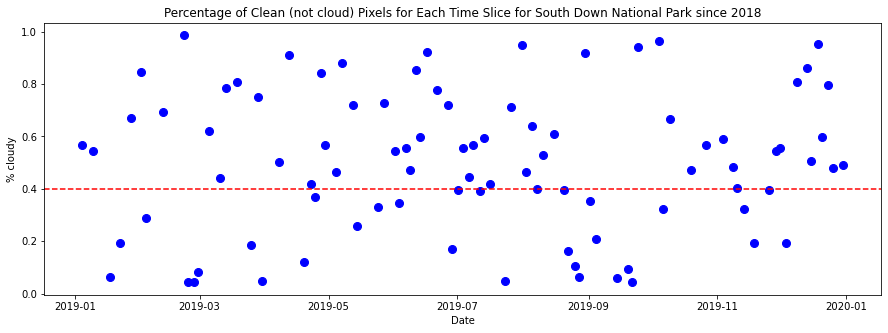

In [4]:
plt.figure(figsize = (15,5))
plt.plot(df["time"].values, df["clean_percentage"].values, 'bo', markersize=8)
plt.axhline(y = 0.4, color = 'r', linestyle = 'dashed')
plt.title("Percentage of Clean (not cloud) Pixels for Each Time Slice for South Down National Park since 2018")
plt.xlabel("Date")
plt.ylabel("% cloudy")
plt.show()

Create NDVI layer

In [5]:
ds['red'] = ds.red.where(ds.fmask==0)
ds['nir2'] = ds.nir2.where(ds.fmask==0)

ds = masking.mask_invalid_data(ds)
ndvi = ((ds.nir2-ds.red)/(ds.nir2+ds.red))
ndvi

<xarray.DataArray (time: 160, y: 4940, x: 11371)>
dask.array<truediv, shape=(160, 4940, 11371), dtype=float64, chunksize=(1, 4940, 11371), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2019-01-02T11:14:41 ... 2019-12-30T11:...
  * y            (y) float64 1.444e+05 1.444e+05 ... 9.506e+04 9.504e+04
  * x            (x) float64 4.466e+05 4.467e+05 ... 5.603e+05 5.603e+05
    spatial_ref  int32 27700

Group the data into monthly medians

In [6]:
ndvi_month_grps = ndvi.groupby('time.month')
ndvi_month_median = ndvi_month_grps.median(dim = 'time')

We 'should' have 12 images - they maybe partial!

In [7]:
ndvi_month_median

,Array,Chunk
Bytes,5.02 GiB,7.10 MiB
Shape,"(12, 4940, 11371)","(1, 494, 1885)"
Count,17985 Tasks,3240 Chunks
Type,float64,numpy.ndarray


Let's next mask the park onto the array to get anactual picture of the national park

In [23]:
month0 = ndvi_month_median.isel(month=0) # rasterize single slice
month0
mask = jncc_utils11.xr_rasterize(gdf, month0, crs=27700)

Rasterizing to match xarray.DataArray dimensions (4940, 11371) and projection system/CRS (e.g. 27700)


And plot up the first month (January)

/home/jovyan/mambaforge/envs/datacube/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


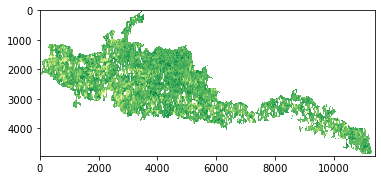

In [24]:
masked_da = ndvi_month_median.where(mask)
plt.imshow(masked_da[0], cmap="RdYlGn")

and August

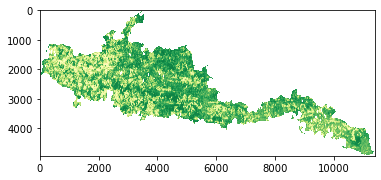

In [25]:
plt.imshow(masked_da[7], cmap="RdYlGn")